# Trees for defaults

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
cr_loan_prep = pd.read_csv("cr_loan_prep.csv", index_col=0)

In [3]:
X = cr_loan_prep.drop(columns=['loan_status'])
y = cr_loan_prep['loan_status']

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

# Train a model
clf_lr = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))
clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

# Predict with a model
lr_preds = clf_lr.predict_proba(X_test)
gbt_preds = clf_gbt.predict_proba(X_test)

# Gradient boosted portfolio performance

In [4]:
portfolio = pd.concat([pd.Series(lr_preds[:,1],), pd.Series(gbt_preds[:,1])], axis=1)
portfolio.rename(columns={0:'lr_prob_default', 1:'gbt_prob_default'}, inplace=True)
portfolio['lgd'] = 0.2
portfolio['loan_amnt'] = X_test['loan_amnt'].values

In [5]:
# Print the first five rows of the portfolio data frame
print(portfolio.head())

# Create expected loss columns for each model using the formula
portfolio['lr_expected_loss'] = portfolio['lr_prob_default'] * portfolio['lgd'] * portfolio['loan_amnt']
portfolio['gbt_expected_loss'] = portfolio['gbt_prob_default'] * portfolio['lgd'] * portfolio['loan_amnt']

# Print the sum of the expected loss for lr
print('LR expected loss: ', np.sum(portfolio['lr_expected_loss']))

# Print the sum of the expected loss for gbt
print('GBT expected loss: ', np.sum(portfolio['gbt_expected_loss']))

   lr_prob_default  gbt_prob_default  lgd  loan_amnt
0         0.130012          0.011106  0.2       9000
1         0.059754          0.167985  0.2       4000
2         0.129564          0.002628  0.2       6300
3         0.456964          0.063230  0.2      12400
4         0.376612          0.189694  0.2       7500
LR expected loss:  5500678.4851673525
GBT expected loss:  5408946.914417118


It looks like the total expected loss for the XGBClassifier() model is quite a bit higher. When we talk about accuracy and precision, the goal is to generate models which have a low expected loss. Looking at a classification_report() helps as well.

# Assessing gradient boosted trees

In [6]:
# Predict the labels for loan status
lr_preds = clf_lr.predict(X_test)
gbt_preds = clf_gbt.predict(X_test)

# Check the values created by the predict method
print(lr_preds)
print(gbt_preds)

# Print the classification report of the model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, lr_preds, target_names=target_names))
print(classification_report(y_test, gbt_preds, target_names=target_names))

[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
              precision    recall  f1-score   support

 Non-Default       0.80      0.98      0.88      9177
     Default       0.73      0.16      0.26      2609

    accuracy                           0.80     11786
   macro avg       0.76      0.57      0.57     11786
weighted avg       0.79      0.80      0.75     11786

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9177
     Default       0.94      0.73      0.82      2609

    accuracy                           0.93     11786
   macro avg       0.94      0.86      0.89     11786
weighted avg       0.93      0.93      0.93     11786



# Column importance and default prediction

When using multiple training sets with many different groups of columns, it's important to keep and eye on which columns matter and which do not. It can be expensive or time-consuming to maintain a set of columns even though they might not have any impact on *loan_status*.

In [7]:
X = cr_loan_prep[['person_income','loan_int_rate',
                  'loan_percent_income','loan_amnt',
                  'person_home_ownership_MORTGAGE','loan_grade_F']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

# Create and train the model on the training data
clf_gbt = xgb.XGBClassifier().fit(X_train,np.ravel(y_train))

# Print the column importances from the model
print(clf_gbt.get_booster().get_score(importance_type = 'weight'))

{'loan_percent_income': 529, 'loan_int_rate': 1046, 'person_income': 1314, 'loan_amnt': 527, 'person_home_ownership_MORTGAGE': 126, 'loan_grade_F': 11}


So, the importance for loan_grade_F is only 11 in this case. This could be because there are so few of the F-grade loans. While the F-grade loans don't add much to predictions here, they might affect the importance of other training columns.

# Visualizing column importance

Understanding how different columns are used to arrive at a *loan_status* prediction is very important for model interpretability.

In [8]:
X2 = cr_loan_prep[['loan_int_rate','person_emp_length']]
X3 = cr_loan_prep[['person_income','loan_int_rate','loan_percent_income']]

X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=.4, random_state=123)
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=.4, random_state=123)

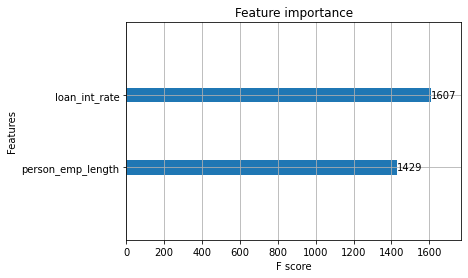

In [9]:
# Train a model on the X data with 2 columns
clf_gbt2 = xgb.XGBClassifier().fit(X2_train,np.ravel(y_train))

# Plot the column importance for this model
xgb.plot_importance(clf_gbt2, importance_type = 'weight')
plt.show()

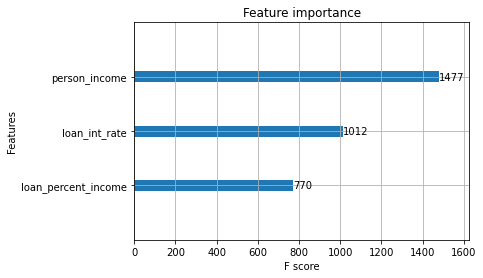

In [10]:
# Train a model on the X data with 3 columns
clf_gbt3 = xgb.XGBClassifier().fit(X3_train,np.ravel(y_train))

# Plot the column importance for this model
xgb.plot_importance(clf_gbt3, importance_type = 'weight')
plt.show()

Initially, *loan_int_rate* was the most important column, but *person_income* ended up taking the top spot here.

# Column selection and model performance

Creating the training set from different combinations of columns affects the model and the importance values of the columns. Does a different selection of columns also affect the F-1 scores, the combination of the precision and recall, of the model? We can answer this question by training two different models on two different sets of columns, and checking the performance.

Inaccurately predicting defaults as non-default can result in unexpected losses if the probability of default for these loans was very low. We can use the F-1 score for defaults to see how the models will accurately predict the defaults.

In [11]:
X = cr_loan_prep[['person_income', 'loan_int_rate', 'loan_percent_income', 'loan_amnt', 'person_home_ownership_MORTGAGE']]
X2 = cr_loan_prep[['person_income', 'loan_int_rate', 'loan_percent_income', 'person_emp_length', 'person_home_ownership_RENT']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=.4, random_state=123)

gbt = xgb.XGBClassifier().fit(X_train,np.ravel(y_train))
gbt2 = xgb.XGBClassifier().fit(X2_train,np.ravel(y_train))

In [12]:
# Predict the loan_status using each model
gbt_preds = gbt.predict(X_test)
gbt2_preds = gbt2.predict(X2_test)

# Print the classification report of the first model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

# Print the classification report of the second model
print(classification_report(y_test, gbt2_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.91      0.96      0.93      9177
     Default       0.81      0.66      0.73      2609

    accuracy                           0.89     11786
   macro avg       0.86      0.81      0.83     11786
weighted avg       0.89      0.89      0.89     11786

              precision    recall  f1-score   support

 Non-Default       0.91      0.98      0.94      9177
     Default       0.90      0.65      0.75      2609

    accuracy                           0.91     11786
   macro avg       0.90      0.81      0.85     11786
weighted avg       0.90      0.91      0.90     11786



It looked like the selection of columns affected model accuracy the most, but now we see that the selection of columns also affects recall by quite a bit

# Cross validating credit models

Credit loans and their data change over time, and it won't always look like what's been loaded into the current test sets. So, we can use cross-validation to try several smaller training and test sets which are derived from the original *X_train* and *y_train*.

In [13]:
X = cr_loan_prep.drop(columns=['loan_status'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)
params = {'eval_metric': 'auc', 'objective': 'binary:logistic', 'seed': 123}

# Set the values for number of folds and stopping iterations
n_folds = 5
early_stopping = 10

# Create the DTrain matrix for XGBoost
Dtrain = xgb.DMatrix(X_train, label = y_train)

# Create the data frame of cross validations
cv_df = xgb.cv(params, Dtrain, num_boost_round = 5, nfold=n_folds,
            early_stopping_rounds=early_stopping)

# Print the cross validations data frame
print(cv_df)

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.903058       0.001980       0.898697      0.008435
1        0.909570       0.001214       0.903772      0.007847
2        0.913940       0.001938       0.908188      0.007294
3        0.918344       0.001861       0.911168      0.006633
4        0.922192       0.001223       0.915421      0.007330


# Limits to cross-validation testing

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.903207       0.001835       0.898498      0.007795
1        0.909165       0.001227       0.904436      0.009030
2        0.913430       0.001430       0.908275      0.009130
3        0.917865       0.000877       0.911602      0.009454
4        0.921801       0.000827       0.915208      0.009788
0.945127817166667


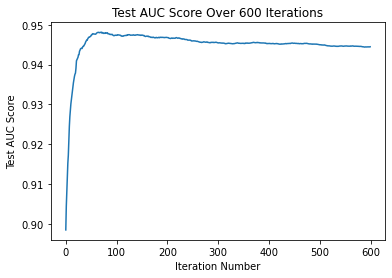

In [14]:
Dtrain = xgb.DMatrix(X_train, label = y_train)
cv_results_big = xgb.cv(params, Dtrain, num_boost_round = 600, nfold=10,
            shuffle = True)

# Print the first five rows of the CV results data frame
print(cv_results_big.head())

# Calculate the mean of the test AUC scores
print(np.mean(cv_results_big['test-auc-mean']))


# Plot the test AUC scores for each iteration
plt.plot(cv_results_big['test-auc-mean'])
plt.title('Test AUC Score Over 600 Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Test AUC Score')
plt.show()

Notice that the test AUC score never quite reaches 1.0 and begins to decrease slightly after 100 iterations. This is because this much cross-validation can actually cause the model to become overfit. So, there is a limit to how much cross-validation you should to.

# Cross-validation scoring

In [16]:
# Create a gradient boosted tree model using two hyperparameters
gbt = xgb.XGBClassifier(learning_rate= 0.1, max_depth= 7)

# Calculate the cross validation scores for 4 folds
cv_scores = cross_val_score(gbt, X_train, np.ravel(y_train), cv = 4)

# Print the cross validation scores
print(cv_scores)

# Print the average accuracy and standard deviation of the scores
print("Average accuracy: %0.3f (+/- %0.3f)" % (cv_scores.mean(),
                                              cv_scores.std() * 2))

[0.93393665 0.93482688 0.93641095 0.93030097]
Average accuracy: 0.934 (+/- 0.004)


With only a couple of hyperparameters and cross-validation, we can get the average accuracy up to 93%. This is a great way to validate how robust the model is.

# Undersampling training data

In [17]:
X_y_train = pd.concat([X_train.reset_index(drop = True),
                       y_train.reset_index(drop = True)], axis = 1)
count_nondefault, count_default = X_y_train['loan_status'].value_counts()

In [19]:
y_train.value_counts()

0    13823
1     3854
Name: loan_status, dtype: int64

In [20]:
# Create data sets for defaults and non-defaults
nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults = X_y_train[X_y_train['loan_status'] == 1]

# Undersample the non-defaults
nondefaults_under = nondefaults.sample(count_default)

# Concatenate the undersampled nondefaults with defaults
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

# Print the value counts for loan status
print(X_y_train_under['loan_status'].value_counts())

1    3854
0    3854
Name: loan_status, dtype: int64


Our training set has an even number of defaults and non-defaults. Let's test out some machine learning models on this new undersampled data set and compare their performance to the models trained on the regular data set.

# Undersampled tree performance

The performance of the model's predictions not only impact the probability of default on the test set, but also on the scoring of new loan applications as they come in. We also now know that it is even more important that the recall of defaults be high, because a default predicted as non-default is more costly.

In [21]:
# Check the classification reports
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))
print(classification_report(y_test, gbt2_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.91      0.96      0.93      9177
     Default       0.81      0.66      0.73      2609

    accuracy                           0.89     11786
   macro avg       0.86      0.81      0.83     11786
weighted avg       0.89      0.89      0.89     11786

              precision    recall  f1-score   support

 Non-Default       0.91      0.98      0.94      9177
     Default       0.90      0.65      0.75      2609

    accuracy                           0.91     11786
   macro avg       0.90      0.81      0.85     11786
weighted avg       0.90      0.91      0.90     11786



In [24]:
# Print the confusion matrix for both old and new models
print(confusion_matrix(y_test,gbt_preds))
print(confusion_matrix(y_test,gbt2_preds))

[[8779  398]
 [ 897 1712]]
[[8987  190]
 [ 924 1685]]


In [27]:
# Print and compare the AUC scores of the old and new models
print(roc_auc_score(y_test, gbt_preds))
print(roc_auc_score(y_test, gbt2_preds))

0.8064104091782441
0.8125686923827141


Undersampling the training data results in more false positives, but the recall for defaults and the AUC score are both higher than the original model. This means overall it predicts defaults much more accurately.